# Space Weather 2009 - 2020

In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

import pandas as pd

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
#plt.rcParams['axes.ymargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
fname = "OMNI2_H0_MRG1HR_227742.csv"
date_col = 'TIME_AT_CENTER_OF_HOUR_yyyy-mm-ddThh:mm:ss.sssZ'
df = pd.read_csv(fname,parse_dates=[date_col],comment="#")
df.rename(columns={date_col:'Time_UT'},inplace=True)

df['Time_UT'] = df['Time_UT'].map(lambda x:x.replace(tzinfo=None))
df.set_index('Time_UT',inplace=True)

In [4]:
df

,DAILY_SUNSPOT_NO_,DAILY_F10.7_,3-H_KP*10_,1-H_DST_nT,1-H_AE_nT,3-H_AP_nT,1-H_PC(N)-INDEX_,PROTON_QI_
Time_UT,,,,,,,,
2009-01-01 00:30:00,0,66.6,17,-7,44,6,0.9,0.0206
2009-01-01 01:30:00,0,66.6,17,-5,51,6,0.6,0.0177
2009-01-01 02:30:00,0,66.6,17,-4,68,6,0.9,0.0111
2009-01-01 03:30:00,0,66.6,23,-5,75,9,0.8,0.0197
2009-01-01 04:30:00,0,66.6,23,-7,153,9,1.9,0.0087
...,...,...,...,...,...,...,...,...
2019-12-31 19:30:00,0,68.2,13,-2,9999,5,0.4,0.0071
2019-12-31 20:30:00,0,68.2,13,-1,9999,5,0.5,0.0086
2019-12-31 21:30:00,0,68.2,7,-1,9999,3,0.5,0.0052


In [5]:
df.columns

Index(['DAILY_SUNSPOT_NO_', 'DAILY_F10.7_', '3-H_KP*10_', '1-H_DST_nT',
       '1-H_AE_nT', '3-H_AP_nT', '1-H_PC(N)-INDEX_', 'PROTON_QI_'],
      dtype='object')

In [6]:
prms  = {}
prms['DAILY_F10.7_'] = {'bad':900}
prms['3-H_KP*10_']   = {}
prms['1-H_DST_nT']   = {}
prms['1-H_AE_nT']    = {'bad':9999}

#prms['DAILY_SUNSPOT_NO_'] = {}
#prms['DAILY_F10.7_'] = {}
#prms['3-H_KP*10_'] = {}
#prms['1-H_DST_nT'] = {}
#prms['1-H_AE_nT'] = {}
#prms['3-H_AP_nT'] = {}
#prms['1-H_PC(N)-INDEX_'] = {}
#prms['PROTON_QI_'] = {}

In [7]:
# Set NaNs
for prm,prmd in prms.items():
    bad = prmd.get('bad')
    if bad:
        tf = df[prm] >= bad
        df.loc[tf,prm] = np.nan
        print(prm,bad)

DAILY_F10.7_ 900
1-H_AE_nT 9999


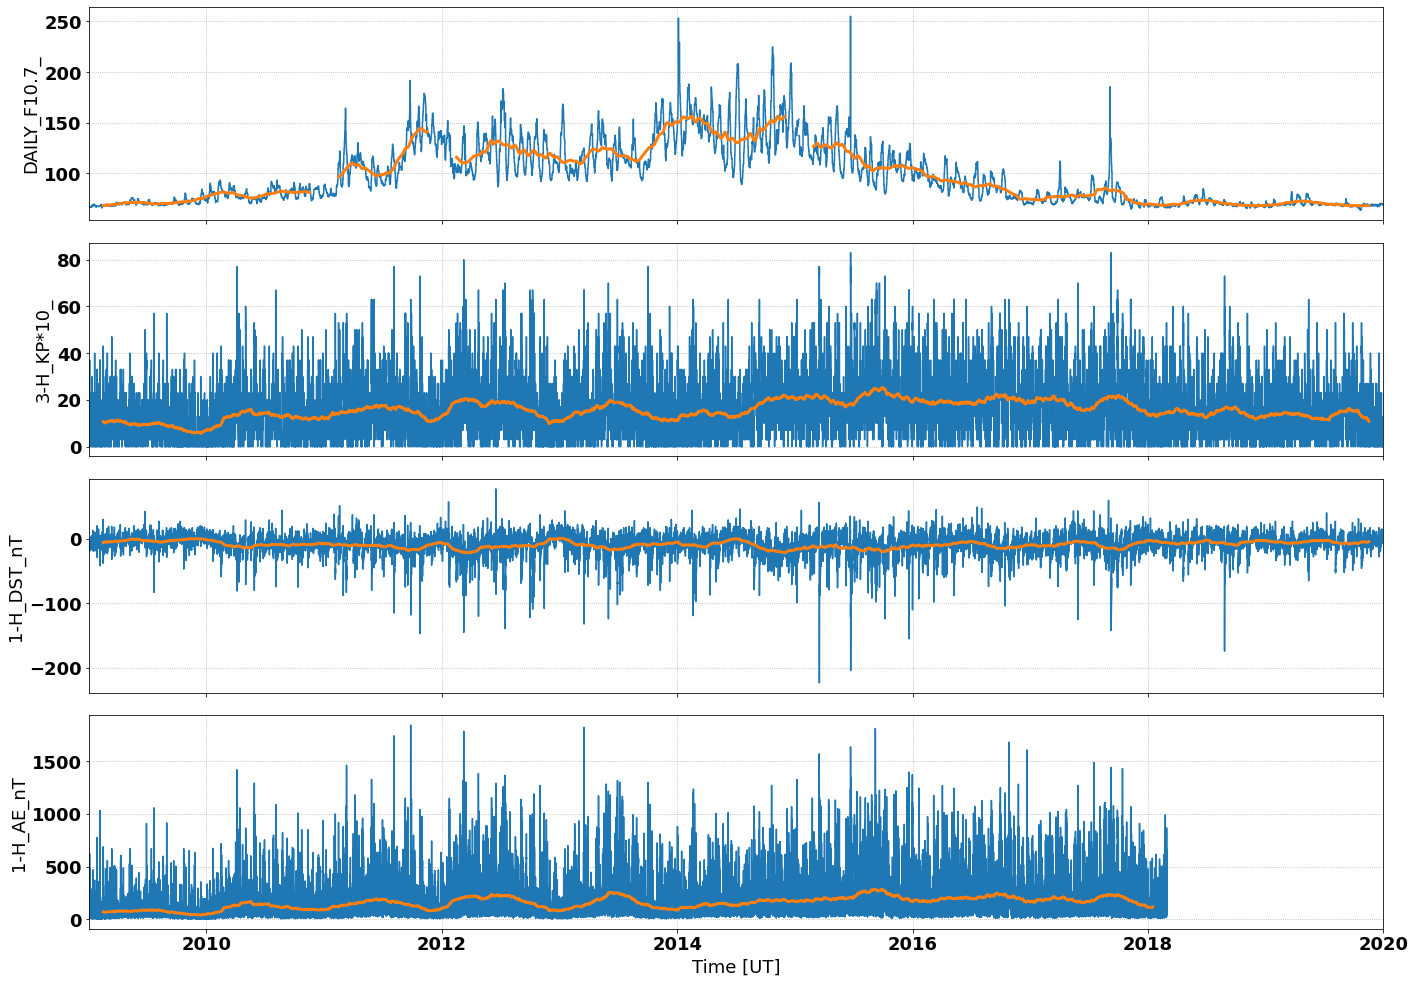

In [9]:
sTime = datetime.datetime(2009,1,1)
eTime = datetime.datetime(2020,1,1)
plot_spectrogram = False

xlim  = (sTime,eTime)

nrows = len(prms)
if plot_spectrogram:
    nrows += len(prms)

fig = plt.figure(figsize=(20,nrows*3.5))
ax_inx = 0
axs      = []
axs_spec = []
for prm,prmd in prms.items():
    prm_lbl = prmd.get('label',prm)
    xx      = df.index
    yy      = df[prm]    
    yy_filt = yy.rolling(90*24,center=True).apply(lambda x: np.nanmean(x))
    
    ax_inx += 1
    ax  = fig.add_subplot(nrows,1,ax_inx)
    axs.append(ax)   
    ax.plot(xx,yy)
    ax.plot(xx,yy_filt,lw=3)
    ax.set_xlim(xlim)
    ax.set_ylabel(prm_lbl)    
    if ax_inx != nrows:
        ax.set_xticklabels([])        
              
    if plot_spectrogram:
        ax_inx += 1
        ax  = fig.add_subplot(nrows,1,ax_inx)
        axs_spec.append(ax)
        f_spec, t_spec, Sxx = signal.spectrogram(yy_filt, 24) # Samples Per Day
        xx_spec = [df.index[0] + datetime.timedelta(days=x) for x in t_spec]
        mpbl = ax.pcolormesh(xx_spec, f_spec, 10.*np.log10(Sxx)[:-1,:-1])
        cbar = fig.colorbar(mpbl,label='PSD [dB]')
        ax.set_ylabel(prm+'\nFrequency [Day$^{-1}$]')
        ax.set_xlim(xlim)
        ax.set_ylim(0,2)

        if ax_inx != nrows:
            ax.set_xticklabels([])
        
    if ax_inx == nrows:
        ax.set_xlabel('Time [UT]')  

fig.tight_layout()

if plot_spectrogram:
    widths = []
    for ax in axs_spec:
        widths.append(ax.get_position().bounds[2])
    spec_width = max(widths)

    for ax in axs + axs_spec:
        axp = ax.get_position().bounds
        ax.set_position((axp[0],axp[1],spec_width,axp[3]))
            
plt.show()